# Lecture 3: Introduction to Monte Carlo Methods
In the last lecture we learned how to do Bayesian econometrics:
1. Build a model
2. Form prior beliefs about the model parameters
3. Compute the posterior beliefs about the model parameters
4. Present the results: posterior analysis, hypothesis testing and/or prediction 

To illustrate this procedure, we considered an experiment in which we wanted to estimate the probability that a coin flip will show Heads. A nice feature of the model we used was that the resulting posterior distribution was a known distribution and the moments that we computed had analytical solutions. Unfortunately this is not always the case. In practice, most of the models that we work with will have posterior distributions that are of unknown form. It's also common to have posterior quantities of interest (e.g. moments and probabilities) that have no analytical solution. In this lecture we will show how to overcome this problem using [Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method). First, we load some useful packages.

In [1]:
# Add some packages 
using Pkg
Pkg.add("Distributions")    # Allows us to work with standard probability distributions
Pkg.add("Interact")         # Allows us to create widgets which are useful for visualizing probability distributions
Pkg.add("SpecialFunctions") # Allows us to evaluate the Beta function
Pkg.add("Plots")            # Allows us to create histograms

# Use packages 
using Distributions  
using Interact 
using SpecialFunctions 
using Plots

   Updating registry at `C:\Users\jamie\.julia\registries\General`
  Resolving package versions...
No Changes to `C:\Users\jamie\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\jamie\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\jamie\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\jamie\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...
No Changes to `C:\Users\jamie\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\jamie\.julia\environments\v1.5\Manifest.toml`
  Resolving package versions...


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1784535467297511780\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-8122993471688594373\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1784535467297511780\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

No Changes to `C:\Users\jamie\.julia\environments\v1.5\Project.toml`
No Changes to `C:\Users\jamie\.julia\environments\v1.5\Manifest.toml`


## Monte Carlo Methods
[Monte Carlo methods](https://en.wikipedia.org/wiki/Monte_Carlo_method) (also known as Monte Carlo experiments or simulations) are a class of algorithms that approximate quantities of interest by randomly sampling from a probability distribution. As Bayesians, Monte Carlo methods can be viewed as a class of numerical algorithms that allow us to construct empirical posterior distributions and their associated quantities of interest (e.g. moments or probabilities). The two methods most commonly employed are
1. Posterior simulation
2. Posterior integration

### Posterior simulation
Posterior simulation refers to the use of Monte Carlo simulation methods (also known as Monte Carlo sampling) to obtain draws from the posterior distribution. The most common Monte Carlo sampling method that we use is called direct Sampling. That is, we directly draw from the posterior distribution:
$$
\theta_i \sim p(\theta|\mathbf{y}), \quad i=1,\dots,R
$$
and then use these draws to learn approximate the posterior distribution. This is because the empirical distribution of the simulations $g(\theta_1,\dots,\theta_R|\mathbf{y})$ will converge in distribution to the true posterior $ p(\theta|\mathbf{y})$ as $R\to\infty$. For a finite number of draws, the empirical distribution will approximate the true posterior distribution. Since we control the simulation size $R$, we can estimate the expectation arbitrarily well (or poorly). Since we are approximating the true posterior distribution using simulations, this procedure is known as posterior simulation.

**Example:** In the Julia code below, we approximate the shape of a standard Normal distribution using direct Monte Carlo sampling. Notice that the approximation gets better as the simulation size increases. 

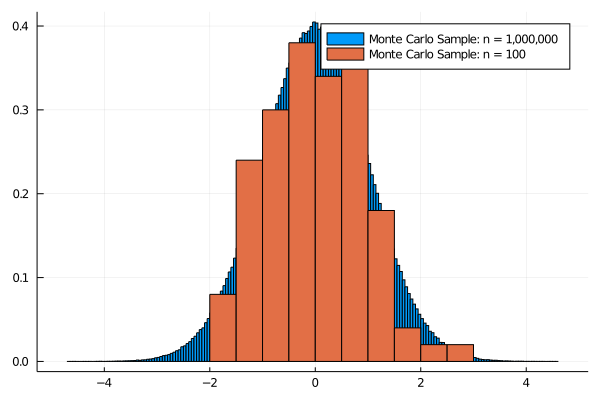

In [2]:
# Approximate the shape of a standard Normal distribution using direct Monte Carlo sampling

dist = Normal(0,1);

# Monte Carlo sample 1
R = 1000000;
z = rand(dist, R);
x = collect(-5:0.1:5);
histogram(x,z, normalize=:pdf, label="Monte Carlo Sample: n = 1,000,000")

# Monte Carlo sample 2
R = 100;
z = rand(dist, R);
p1 = histogram!(x,z, normalize=:pdf, label="Monte Carlo Sample: n = 100")


### Integration
After deriving, or approximating, the posterior distribution, we often want to compute quantities of interest, e.g. moments and probabilities. Such quantities generally require us to compute integrals of the form
$$
\mathbb{E}(f(\theta)|\mathbf{y}) = \int_\Theta f(\theta)p(\theta|\mathbf{y})d\theta.
$$
For instance, the posterior mean is defined by setting $f(\theta)=\theta$, i.e.
$$
\mathbb{E}(\theta|\mathbf{y}) = \int_\Theta \theta p(\theta|\mathbf{y})d\theta,
$$
and the posterior variance is defined by setting $f(\theta)=\theta^2$
$$
\mathbb{E}(\theta^2|\mathbf{y}) = \int_\Theta \theta^2 p(\theta|\mathbf{y})d\theta.
$$
In some cases, such as the coin flip model from the first lecture, such integrals will have analytical solutions. However in many cases, they will not. In such cases we we can use Monte Carlo integration to provide a numerical approximation to the integral. 

Put simply, Monte Carlo integration is the use of Monte Carlo methods to solve integrals. To do so, the only prerequisite is that we know how to obtain samples from the posterior distribution $p(\theta|\mathbf{y})$. Assuming that this is the case, then we generate $R$ draws $\theta_{1},\dots,\theta_{R}$ from the posterior distribution $p(\theta|\mathbf{y})$, and compute
$$
\hat{f}(\theta) = \frac{1}{R} \sum_{r=1}^{R}f(\theta_{r}) 
$$
By the [weak law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers#Weak_law), the Monte Carlo approximation $\hat{f}$, converges weakly in probability to $\mathbb{E}(f(\theta)|\mathbf{y})$ as R tends to infinity. 

**Example**: Suppose that we are interested in the posterior mean $\mathbb{E}(\theta|\mathbf{y})$. The Monte Carlo approximation is
$$
\hat{\theta} = \frac{1}{R} \sum_{r=1}^{R}\theta_{r}
$$
Similarly, the Monte Carlo approximation to the posterior variance is
$$
\hat{\sigma}^2 = \frac{1}{R}\sum_{r=1}^{R}(\theta_{r} - \hat{\theta})^2
$$



In [3]:
# Estimating the mean and variance of a standard Normal distribution N(0,1)

# Specify distribution
dist = Normal(0,1);

# Monte Carlo integration
R = 10000;
x = rand(dist, R);
@show mu = mean(x);
@show sig2 = var(x; corrected=false); # Julia order of operations: var(x; corrected=false) = sum((x.-mean(x)).^2/R);
@show NSE = sqrt(sig2/R);


mu = mean(x) = -0.004548993637210265
sig2 = var(x; corrected = false) = 1.0020266762943912
NSE = sqrt(sig2 / R) = 0.010010128252397124


**Example**: To be accepted as a graduate student at many universities in the United States and Canada, you need to obtain a certain score in the Graduate Record Examinations (GRE). Using data on individuals who tested between July 1, 2016, and June 30, 2019, [GRE administrators report](https://www.ets.org/s/gre/pdf/gre_guide_table1a.pdf) that the mean performance is approximately 307 with a standard deviation of 18. Assuming that GRE scores are normally distributed, what is the probability of an individual scoring at least 350 on the GRE? We can solve this problem using our knowledge of the Normal distribution. That is, we first use the information to get a Z-score:
$$
Z=\frac{350-307}{18} = 2.38 (2dp)
$$
and then look up the probability in a [standard normal table](https://en.wikipedia.org/wiki/Standard_normal_table) to get
$$
    P(X\geq 350) = 1-P(Z<2.38) = 0.0085 (4dp)
$$
We can alternatively estimate this probability using *Monte Carlo integration*. To do so, we randomly sample from a Normal distribution with mean 307 and standard deviation 18 and then compute the approximation
$$
P(X\geq 350) \approx \frac{1}{R} \sum_{r=1}^{R}\mathbb{1}(X_{r}>350)
$$
where $\mathbb{1}(\cdot)$ is the indicator function. This is done in the following code - notice how the accuracy of the approximation varies with the simulation size.

In [4]:
# Computing the probability of a normal random variable

# Using CDF
using Distributions
dist = Normal(307,18);
p1 = 1-cdf(dist, 350);

# Using Monte Carlo integration
R = 1000000;
x = rand(dist, R);
p2 = length(x[x .> 350.0])/R;

@show p1
@show p2

p1 = 0.00844970621225083
p2 = 0.008549


0.008549

# Worked Example: Random Walk Model
Let $\mathbf{Y}_t=(Y_1,\dots,Y_T)'$ denote a time series of interest. The random walk model for is given by
$$
Y_t = Y_{t-1} + e_t,
$$
in which $Y_0=0$ and $e_t$ is a random variable, typically assumed to have distribution $N(0,\sigma^2)$ with $\sigma^2$ unknown. This model is used in a variety of theories in economics and finance. Two of the most popular are the [random walk hypothesis of stock prices](https://en.wikipedia.org/wiki/Random_walk_hypothesis) and the [Meese-Rogoff random walk hypothesis of nominal exchange rates](https://scholar.harvard.edu/files/rogoff/files/51_jie1983.pdf). 


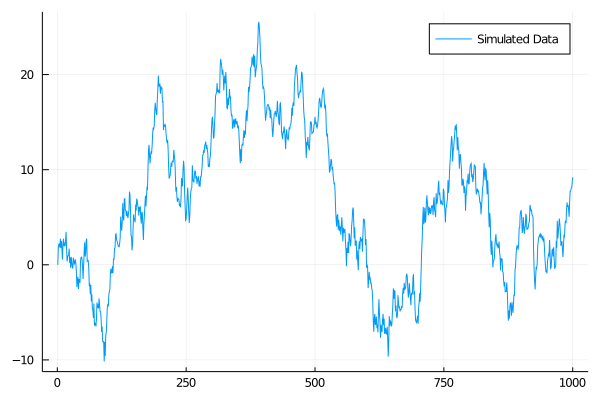

In [41]:
## Simulate Data from random walk model
sig2_true = 1; # true sig2
T = 1000; # no. of dates
y0 = 0;   # initial condition
y = zeros(T); # storage vector

y[1] = y0;
for t = 2:T
    y[t] = y[t-1] + rand(Normal(0,sqrt(sig2_true)));
end
x = collect(1:1:T);
plot(x,y, label="Simulated Data")

We can estimate this model using Bayesian methods. First note that if $e_t\sim N(0,\sigma^2)$, then the above *equation system representation* of the random walk has an equivalent *probability model representation* given by
$$
Y_t\sim N(Y_{t-1},\sigma^2)
$$
This shows that estimating the random walk model is the same as estimating the parameters of the normal distribution with known mean and unknown variance. 

Since the mean of the above distribution is known, we can take it to the left and side and instead work with the *first-difference* of the data $\Delta Y_t=Y_t-Y_{t-1}$ to estimate the model
$$
\Delta Y_t\sim N(0,\sigma^2)
$$

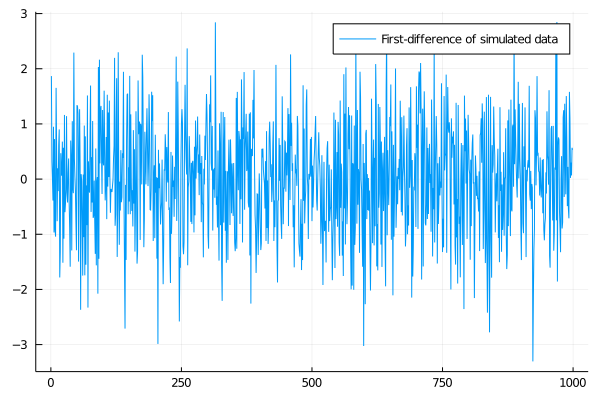

In [42]:
# Plot data in first differences
Dy = y[2:end] - y[1:end-1];
T = length(Dy);
x = collect(1:1:T);
plot(x,Dy, label="First-difference of simulated data")

The likelihood of this model is given by
$$
\begin{align}
p(\mathbf{Y}|\sigma^2) &= \prod_{t=1}^{T}p(\Delta Y_t|\sigma^2)\\
&= \prod_{t=1}^{T}(2\pi\sigma^2)^{-\frac{1}{2}}\exp(-\frac{1}{2\sigma^2}(\Delta Y_t)^2)\\
&= (2\pi\sigma^2)^{-\frac{T}{2}}\exp(-\frac{1}{2\sigma^2}\sum_{t=1}^{T}(\Delta Y_t)^2)
\end{align}
$$

Since $\sigma^2>0$ by definition, it is common to use a prior distribution with support over $(0,\infty)$ such as the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) or [inverse-Gamma distribution](https://en.wikipedia.org/wiki/Inverse-gamma_distribution). Here we will use an inverse-Gamma prior distribution with shape parameter $\nu$ and scale parameter $S$, denoted $IG(\nu,S)$. The pdf is given by
$$
p(\sigma^2) = \frac{S^\nu}{\Gamma(\nu)}(\sigma^2)^{-(\nu+1)}\exp(-\frac{\nu}{\sigma^2})
$$



In [1]:
# Widget showing how the hyperparameters of the inverse-Gamma distribution impact the shape of the pdf
    @manipulate for nu0 in 0:0.1:5, S0 = 0:0.1:5
        RV = InverseGamma(nu0, S0)
        x = collect(0:0.01:5)
        plot(x,pdf(RV, x), title = "Probability density function", legend = false)
    end


LoadError: LoadError: UndefVarError: @manipulate not defined
in expression starting at In[1]:2

To get the posterior, combine the prior and likelihood
$$
\begin{align}
p(\sigma^2|\mathbf{Y}) &\propto p(\mathbf{Y}|\sigma^2) p(\sigma^2)\\
                       &\propto (\sigma^2)^{-\frac{T}{2}}\exp(-\frac{1}{2\sigma^2}\sum_{t=1}^{T}(\Delta Y_t)^2)(\sigma^2)^{-(\nu+1)}\exp(-\frac{S}{\sigma^2})\\
                       &= (\sigma^2)^{-(\frac{T}{2}+\nu+1)}\exp(-\frac{1}{\sigma^2}(S+\frac{1}{2}\sum_{t=1}^{T}(\Delta Y_t)^2)
\end{align}
$$
The final expression shows that the posterior is an inverse-Gamma distribution with scale parameter $\frac{T}{2}+\nu+1$ and shape parameter $S+\frac{1}{2}\sum_{t=1}^{T}(\Delta Y_t)^2$. 

Since this posterior distribution has a known analytical solution we can use properties of the inverse-Gamma distribution to compute moments and quantities of interest. Alternatively, we can approximate them using Monte Carlo methods.

In [2]:
# Prior
nu_pri = 3;
S_pri = 1*(nu_pri-1); # sets E(sig2) = 1
pri = InverseGamma(nu_pri,S_pri);

# Likelihood - for plotting purposes 
like = Normal(0,std(DY));

# Posterior
nu_post = nu_pri + T/2;
S_post = S_pri +0.5*sum(DY.^2);
post = InverseGamma(nu_post,S_post);

# Plot results
plot([x -> pdf(pri, x),x -> pdf(like, x),x -> pdf(post, x)], -3, 3, label = ["Prior" "Likelihood" "Posterior"])

LoadError: UndefVarError: InverseGamma not defined

sig2hat_theory = S_post / (nu_post - 1) = 1.0506046892264576
sig2hat_MC = mean(sig2_MC) = 1.0511009547487675


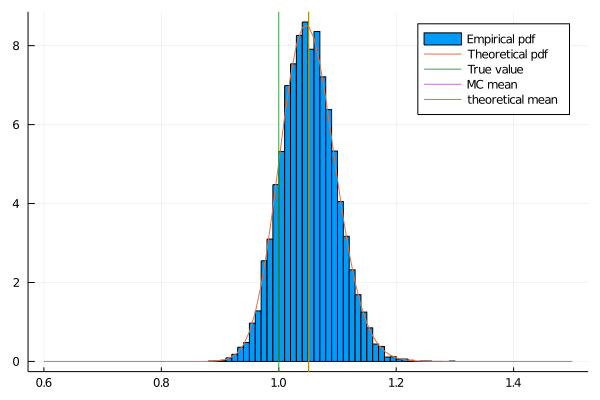

In [32]:
# Compute posterior mean using theoretical formula
@show sig2hat_theory = S_post/(nu_post-1);

## Approximate posterior using direct MC
ndraws = 10000;
sig2_MC = rand(post,ndraws);

# Compute posterior mean using Monte Carlo Integration
@show sig2hat_MC = mean(sig2_MC);

# Plot empirical and theoretical posterior distributions
x = collect(0.6:0.01:1.5);
histogram(x,sig2_MC, normalize=:pdf, label="Empirical pdf")
plot!(x, pdf(post, x), label = "Theoretical pdf")
plot!([sig2_true], seriestype="vline", label="True value")
plot!([sig2hat_MC], seriestype="vline", label="MC mean")
plot!([sig2hat_theory], seriestype="vline", label="theoretical mean")

## Conclusion


## Homework Problems
1. Exercises 11.1 and 11.2 in [Bayesian Econometric Methods (Econometric Exercises)](https://www.amazon.com/Bayesian-Econometric-Methods-Exercises/dp/0521671736)


<!--- HTML tags for comments
If all of the draws $\theta_{1},\dots,\theta_{R}$ from the posterior distribution $p(\theta|\mathbf{y})$ used in our Monte Carlo integration method are iid, and have a finite variance, then we can invoke the [Lindeberg–Lévy central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem#Lindeberg_CLT) to see that as $R\to\infty$
$$
\sqrt{R}(\hat{f}(\theta) - \theta) \to N(0,\sigma^2),
$$
in which $\sigma^2=\text{var}(\theta|\mathbf{y})$ is the standard error. We can estimate this standard error using Monte Carlo integration
$$
\hat{\sigma}^2 = \frac{1}{R}\sum_{r=1}^{R}(\theta_{r} - \hat{\theta})^2
$$
and measure the accuracy of the estimated posterior mean using the numerical standard error
$$
    NSE = \frac{\hat{\sigma}}{\sqrt{R}}
$$
In the Julia code below, we use Monte Carlo integration to approximate the mean and variance of the standard Normal distribution. Notice that the approximation gets better (and the NSE for the posterior mean gets smaller) as the simulation size increases.
We often use the inverse-Gamma (IG) distribution as a prior for random variables that are non-negative. This is because the support of the IG distribution is $(0,\infty)$. We can sample from it in Julia using the function *InverseGamma* from the [Distributions package](https://juliastats.org/Distributions.jl/v0.14/univariate.html). In this example, we will use Monte Carlo sampling to get a feel for the shape this distribution. 
-->
